# Ghost Detection in Keras

Last year, in Advanced Machine Learning, I trained a neural network to be able to detect if a specific house is haunted or not, and later made it generate haunted houses of its own. Unfortunately, the model last year was fundementally flawed. The training dataset was based on manually scraped data from Wikipedia, which was likely inaccurate due to the profitability of claiming a location as haunted. In addition, the generative part of the model seemed rather useless; why would I want to create MORE haunted houses? Even if I can detect if a house is haunted or not, it still wouldn't assist in ghost hunting at all because I wouldn't know where the ghosts actually are, only that they might tend to hang around the area.

This year, I'm creating a model that's better in every way. This model will be able to tell the user where the ghosts actually are so that when the Ghostbusters arrive, they'll know where to look. Getting annotated images of ghosts turned out to be a bit of a problem, however. Luckily, I pulled out my trusty Oujia board, collected on some unpaid debts from my pals in the afterlife, and managed to get a hold of 500 pictures of ghosts, each annotated with a perfect bounding box. 

## SPOILER
Okay, okay. I actually used a Blender script that randomly moves a ghost model around and renders it on a transparent background with a shadow catcher plane. I then threw that on random frames from the CamNeT dataset security footage to generate my "ghost sightings". While all the frames are in the same location, there are people that move around, so it's not totally static.


This notebook follows the tutorial laid out here: https://curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/

I'm currently doing more research into how the ResNet pretrained network works and how residual learning works in general. I plan to resubmit this with a more complete explanation once I feel I completely understand residual learning and how it solves some of the pitfalls of normal CNNs. Since this assignment is already slightly overdue, I guess it's worth mentioning my current understanding:

In theory, CNNs should only get better the more layers you add, but in practice, that's not the case. E.g. if you add more layers, the layers should, at minimum, just refer back to previous layers, so it shouldn't be any worse. However, something called the "vanishing gradient problem," which has to do with how weights are adjusted in the gradient descent algorithm, results in training making very few changes to individual nodes as the loss gets lower. If there were less nodes, the amount to which each node would be changed would increase. Residual learning fixes this by changes how the functions are represented and adds "layer shortcut" inputs in which the to a given node includes the output of a node multiple layers back, ideally making each layer more important.

I'm sure some of that was wrong, but that's as much as I understand right now. Let me know if you have any insight into how this works.

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6205 (delta 1), reused 3 (delta 1), pack-reused 6196
Receiving objects: 100% (6205/6205), 13.48 MiB | 34.58 MiB/s, done.
Resolving deltas: 100% (4196/4196), done.


In [2]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [3]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=168059 sha256=1989d99f69ee43ab4bf0ec65a1ab96adf1df5536e3c1a10ddebb28cc6b723d94
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=42bffd8b23af793f1ab9e970654c551668a3d772dcf6db34bc4c3f8687bcb487
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [4]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [5]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 47kB/s 


In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.makedirs("snapshots", exist_ok=True)

In [9]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:02, 105MB/s]


In [10]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = -1 
with open('/content/drive/My Drive/ML/ghost/bounding_boxes.csv') as csvfile:
    reader = csv.reader(csvfile)
    for bx, by, bwidth, bheight in reader:
        if(counter > -1): # Because the header is the first line
            dataset["image_name"].append(f'/content/drive/My Drive/ML/ghost/composited/{counter}.png')

            dataset["x_min"].append(int(bx))
            dataset["y_min"].append(int(by))
            dataset["x_max"].append(int(bx)+int(bwidth))
            dataset["y_max"].append(int(by)+int(bheight))
            dataset["class_name"].append("ghost")
            
        counter += 1
print("Added {} ghost images.".format(counter))

Added 500 ghost images.


In [11]:
df = pd.DataFrame(dataset)
df.head()

image_name  x_min  ...  y_max  class_name
0  /content/drive/My Drive/ML/ghost/composited/0.png    476  ...    317       ghost
1  /content/drive/My Drive/ML/ghost/composited/1.png    157  ...    341       ghost
2  /content/drive/My Drive/ML/ghost/composited/2.png    118  ...    338       ghost
3  /content/drive/My Drive/ML/ghost/composited/3.png     92  ...    364       ghost
4  /content/drive/My Drive/ML/ghost/composited/4.png    303  ...    398       ghost

[5 rows x 6 columns]

In [12]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

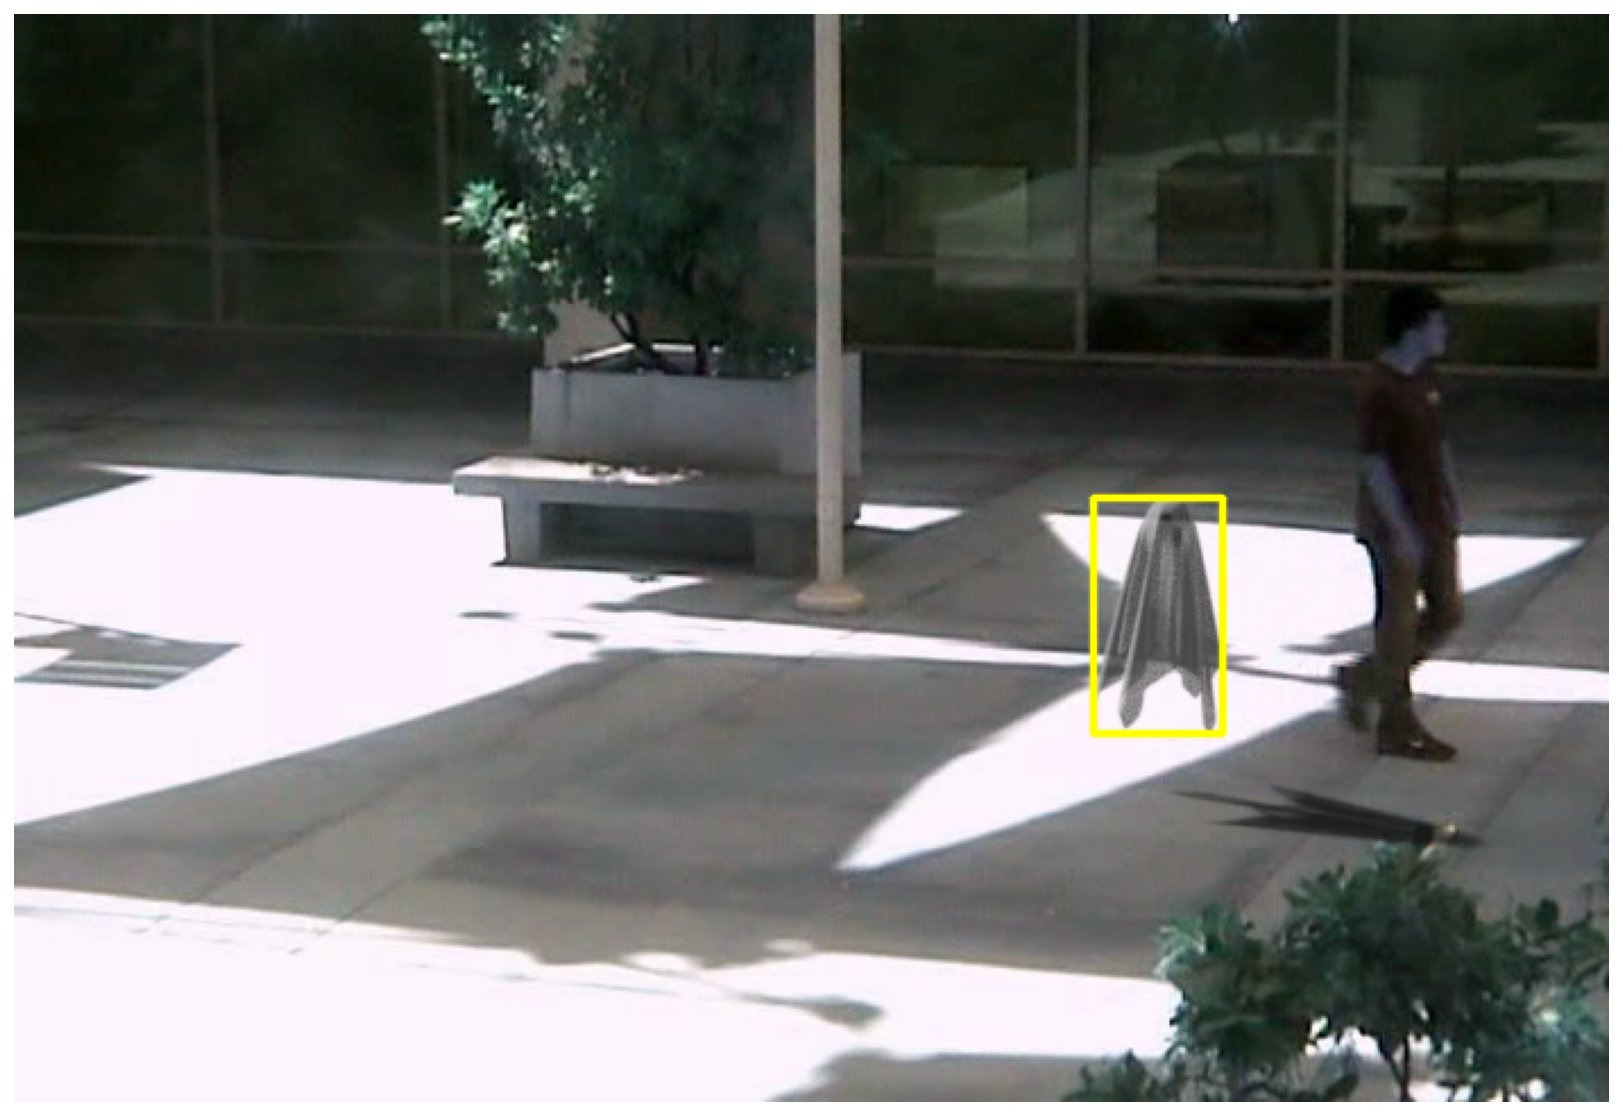

In [13]:
show_image_objects(df.iloc[0])

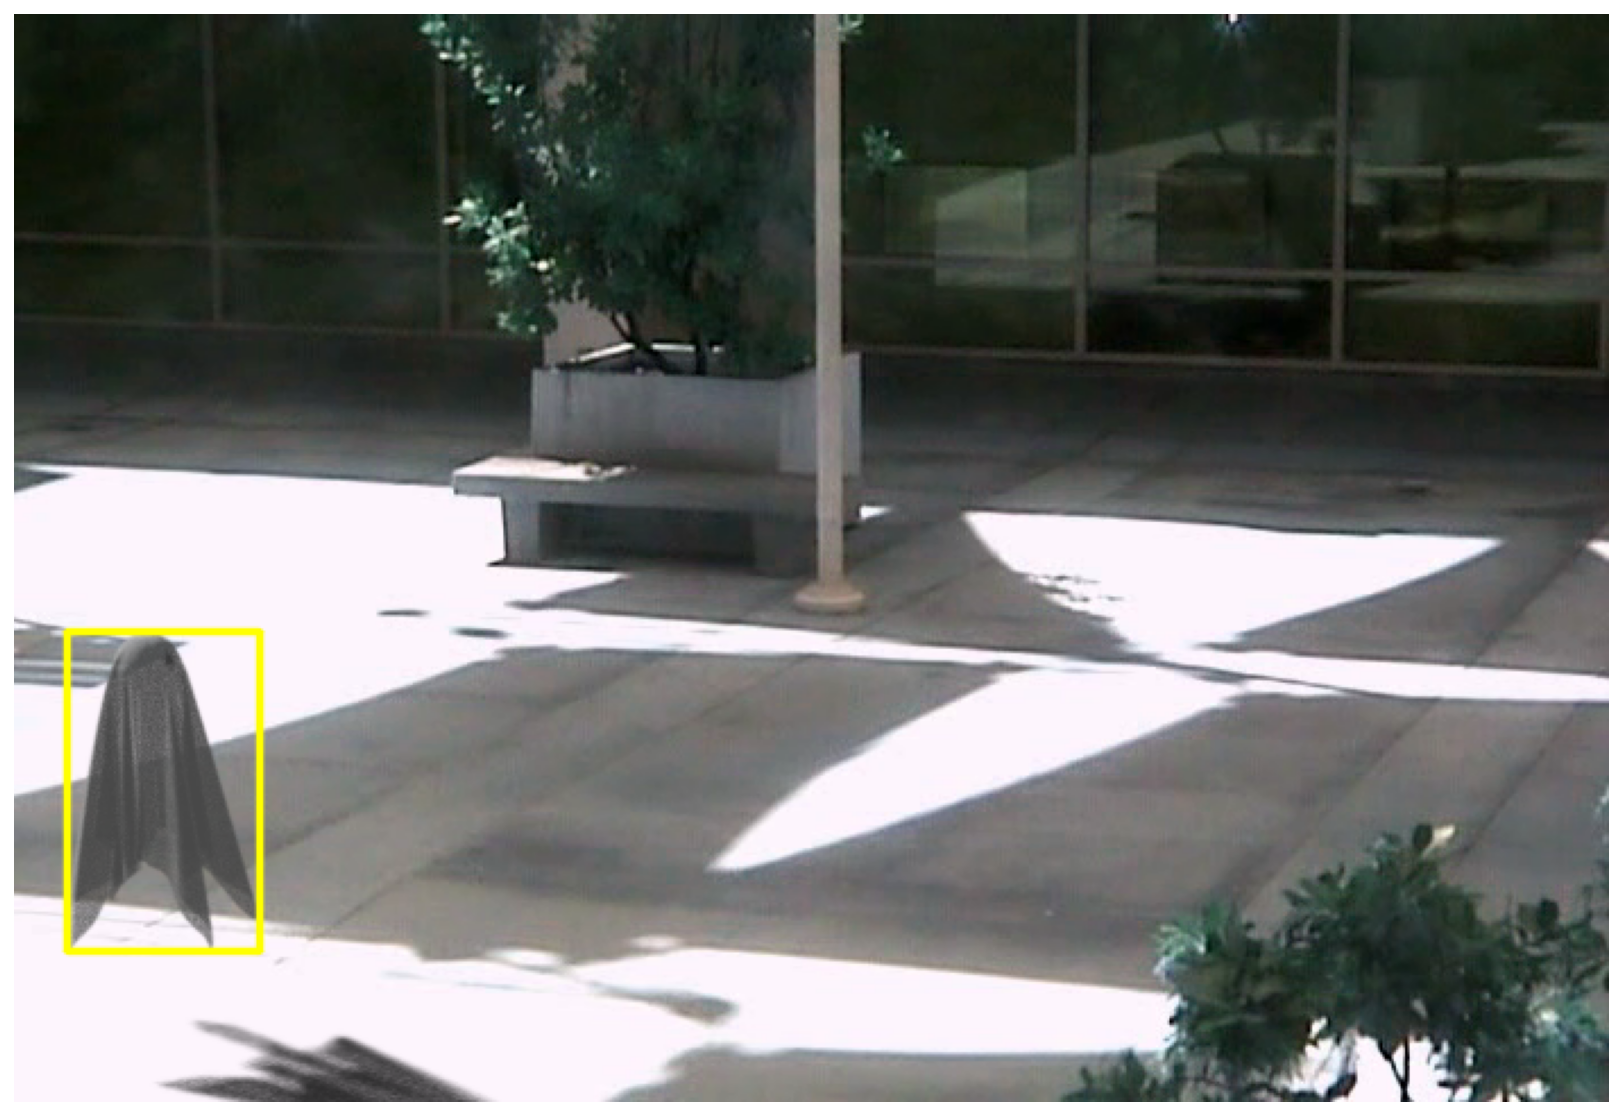

In [14]:
show_image_objects(df.iloc[5])

# Preprocessing

In [15]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [16]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [17]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [18]:
classes = set(['ghost'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [19]:
!head classes.csv

ghost,0


In [20]:
!head annotations.csv

/content/drive/My Drive/ML/ghost/composited/249.png,262,213,320,318,ghost
/content/drive/My Drive/ML/ghost/composited/433.png,439,224,512,337,ghost
/content/drive/My Drive/ML/ghost/composited/19.png,146,229,221,345,ghost
/content/drive/My Drive/ML/ghost/composited/322.png,337,217,407,325,ghost
/content/drive/My Drive/ML/ghost/composited/332.png,406,271,490,415,ghost
/content/drive/My Drive/ML/ghost/composited/56.png,502,206,565,305,ghost
/content/drive/My Drive/ML/ghost/composited/301.png,293,222,353,331,ghost
/content/drive/My Drive/ML/ghost/composited/229.png,64,229,127,343,ghost
/content/drive/My Drive/ML/ghost/composited/331.png,276,206,335,306,ghost
/content/drive/My Drive/ML/ghost/composited/132.png,295,273,389,419,ghost


# Training

In [21]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [22]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

2020-11-05 20:05:29.259005: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-11-05 20:07:17.475876: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-05 20:07:17.530747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-05 20:07:17.531374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-11-05 20:07:17.531431: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-05 20:07:17.725250: I t

# Loading the trained model

In [23]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_01.h5  resnet50_csv_10.h5


In [24]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5


# Predictions

In [25]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [26]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)


In [27]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [28]:
test_df.head(n=10)

image_name  x_min  ...  y_max  class_name
361  /content/drive/My Drive/ML/ghost/composited/36...    192  ...    329       ghost
73   /content/drive/My Drive/ML/ghost/composited/73...     85  ...    341       ghost
374  /content/drive/My Drive/ML/ghost/composited/37...    269  ...    418       ghost
155  /content/drive/My Drive/ML/ghost/composited/15...    279  ...    304       ghost
104  /content/drive/My Drive/ML/ghost/composited/10...    314  ...    303       ghost
394  /content/drive/My Drive/ML/ghost/composited/39...    384  ...    412       ghost
377  /content/drive/My Drive/ML/ghost/composited/37...    520  ...    326       ghost
124  /content/drive/My Drive/ML/ghost/composited/12...    370  ...    294       ghost
68   /content/drive/My Drive/ML/ghost/composited/68...    507  ...    322       ghost
450  /content/drive/My Drive/ML/ghost/composited/45...    134  ...    350       ghost

[10 rows x 6 columns]

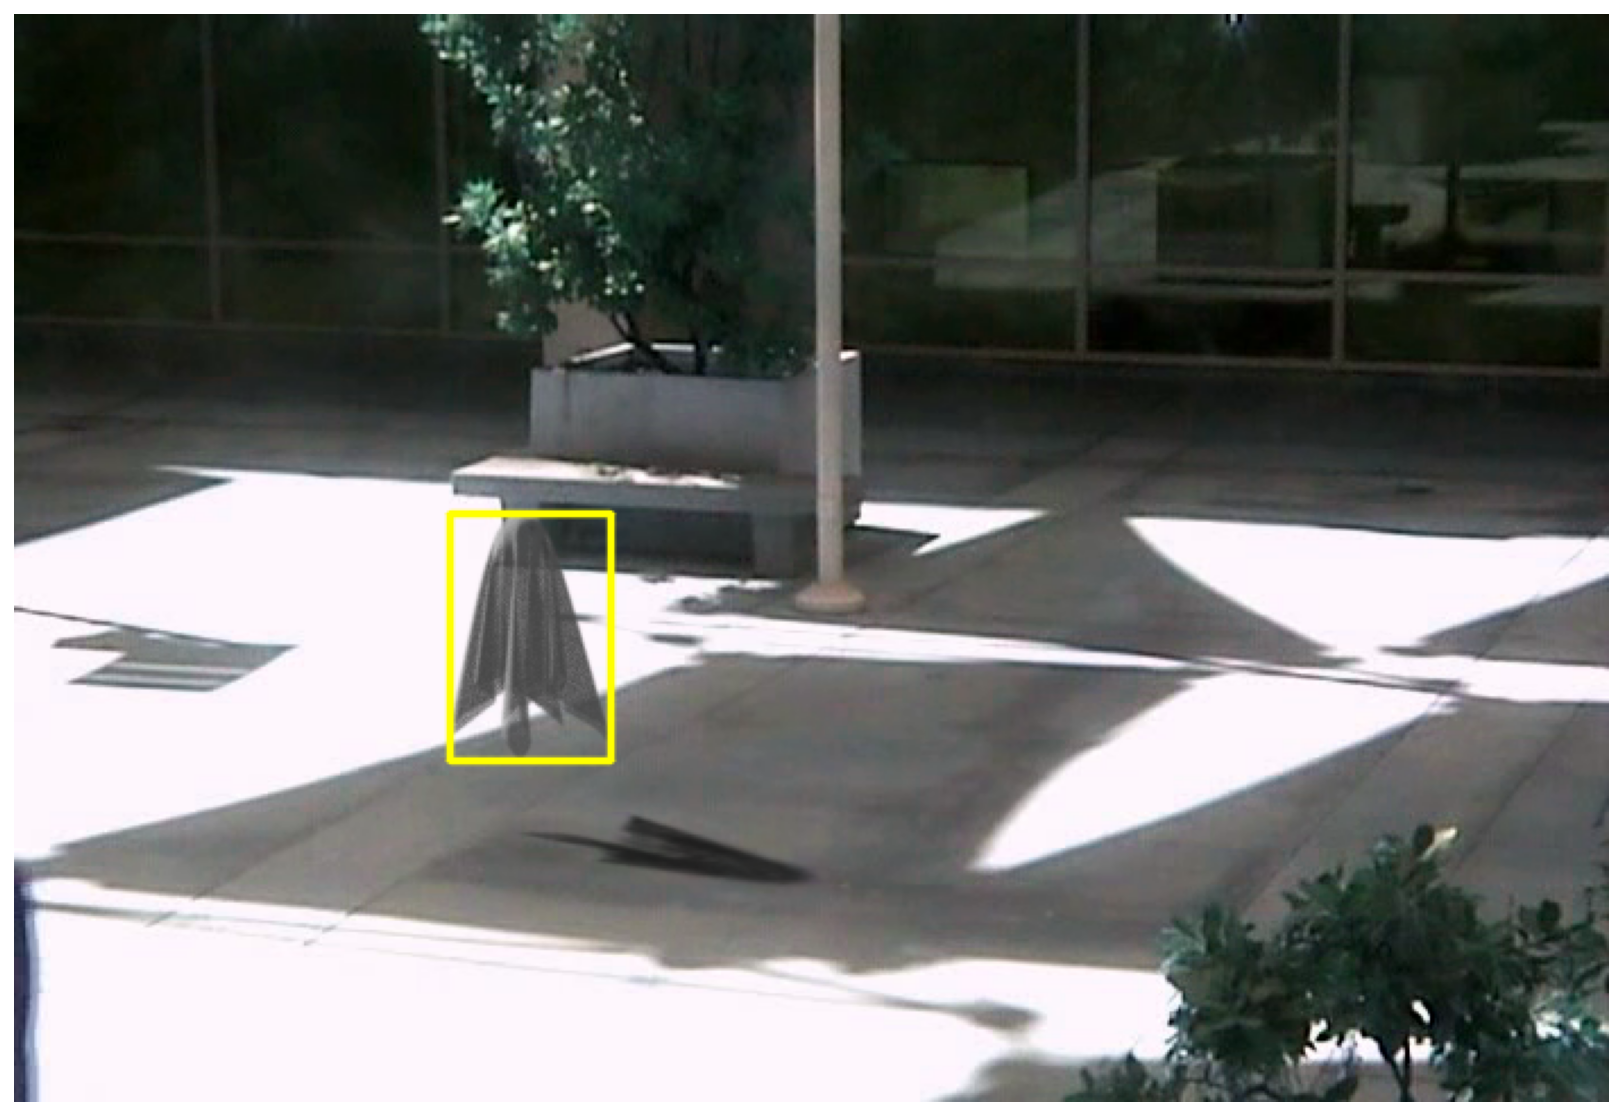

In [29]:
show_detected_objects(test_df.iloc[0])

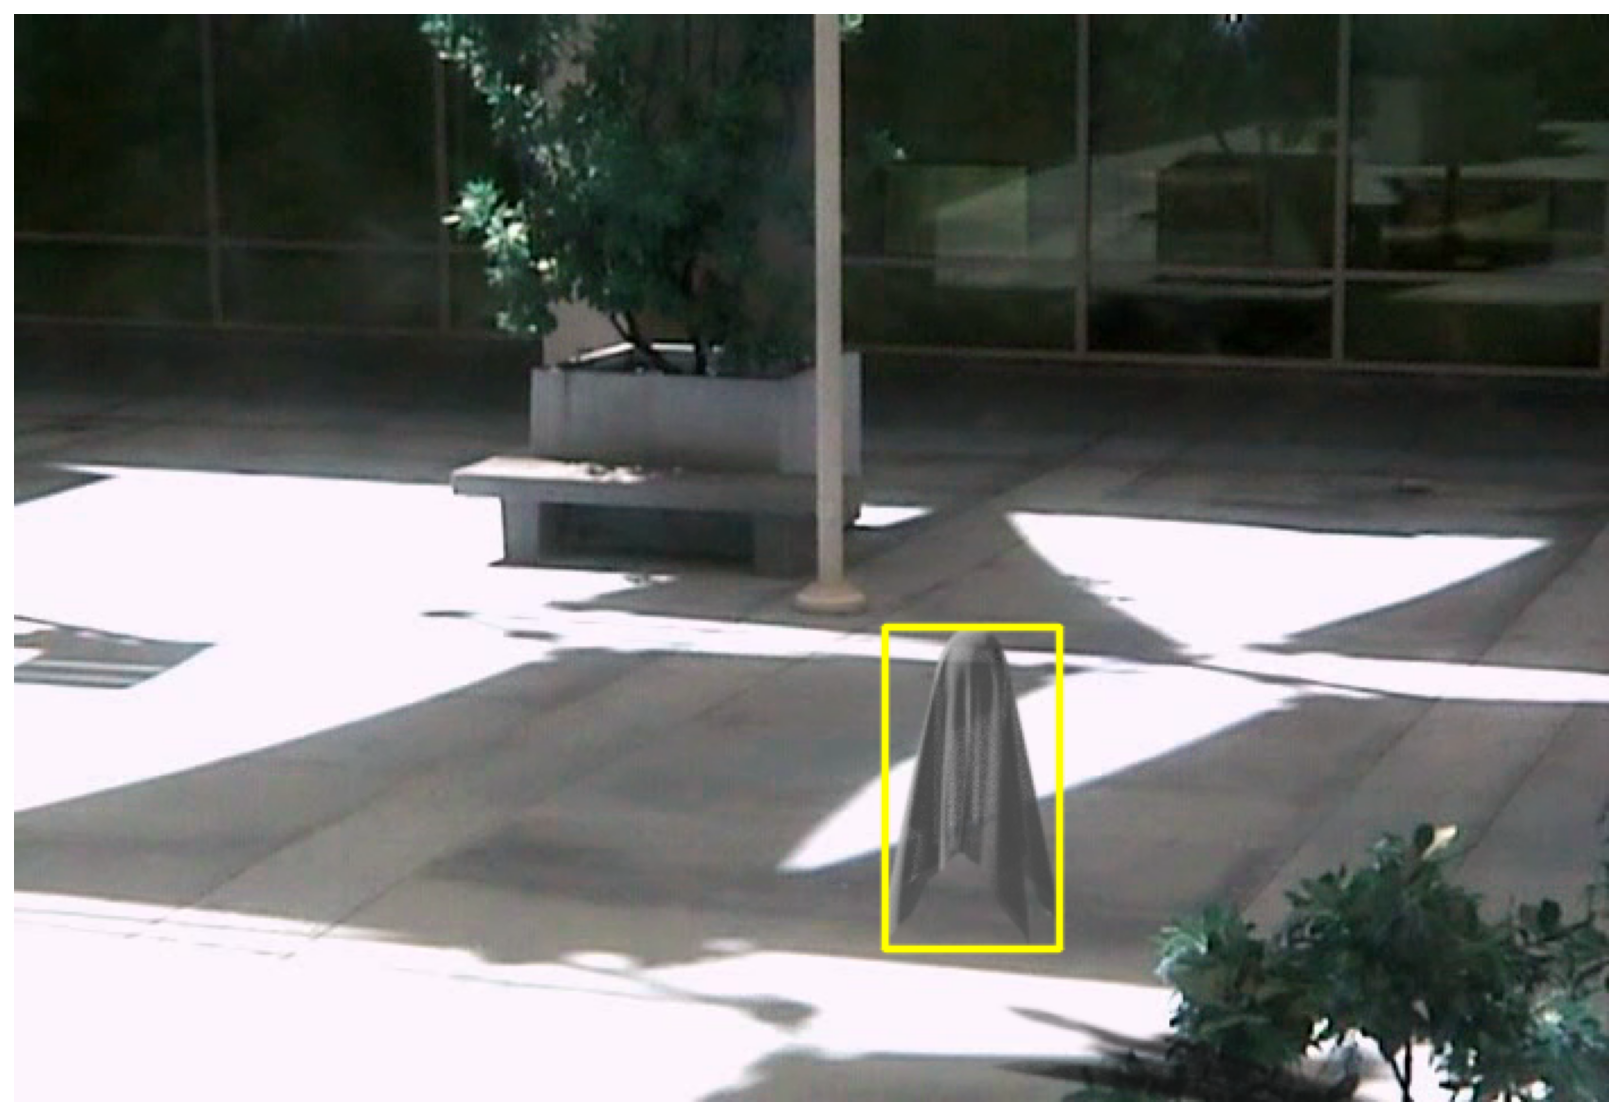

In [30]:
show_detected_objects(test_df.iloc[5])

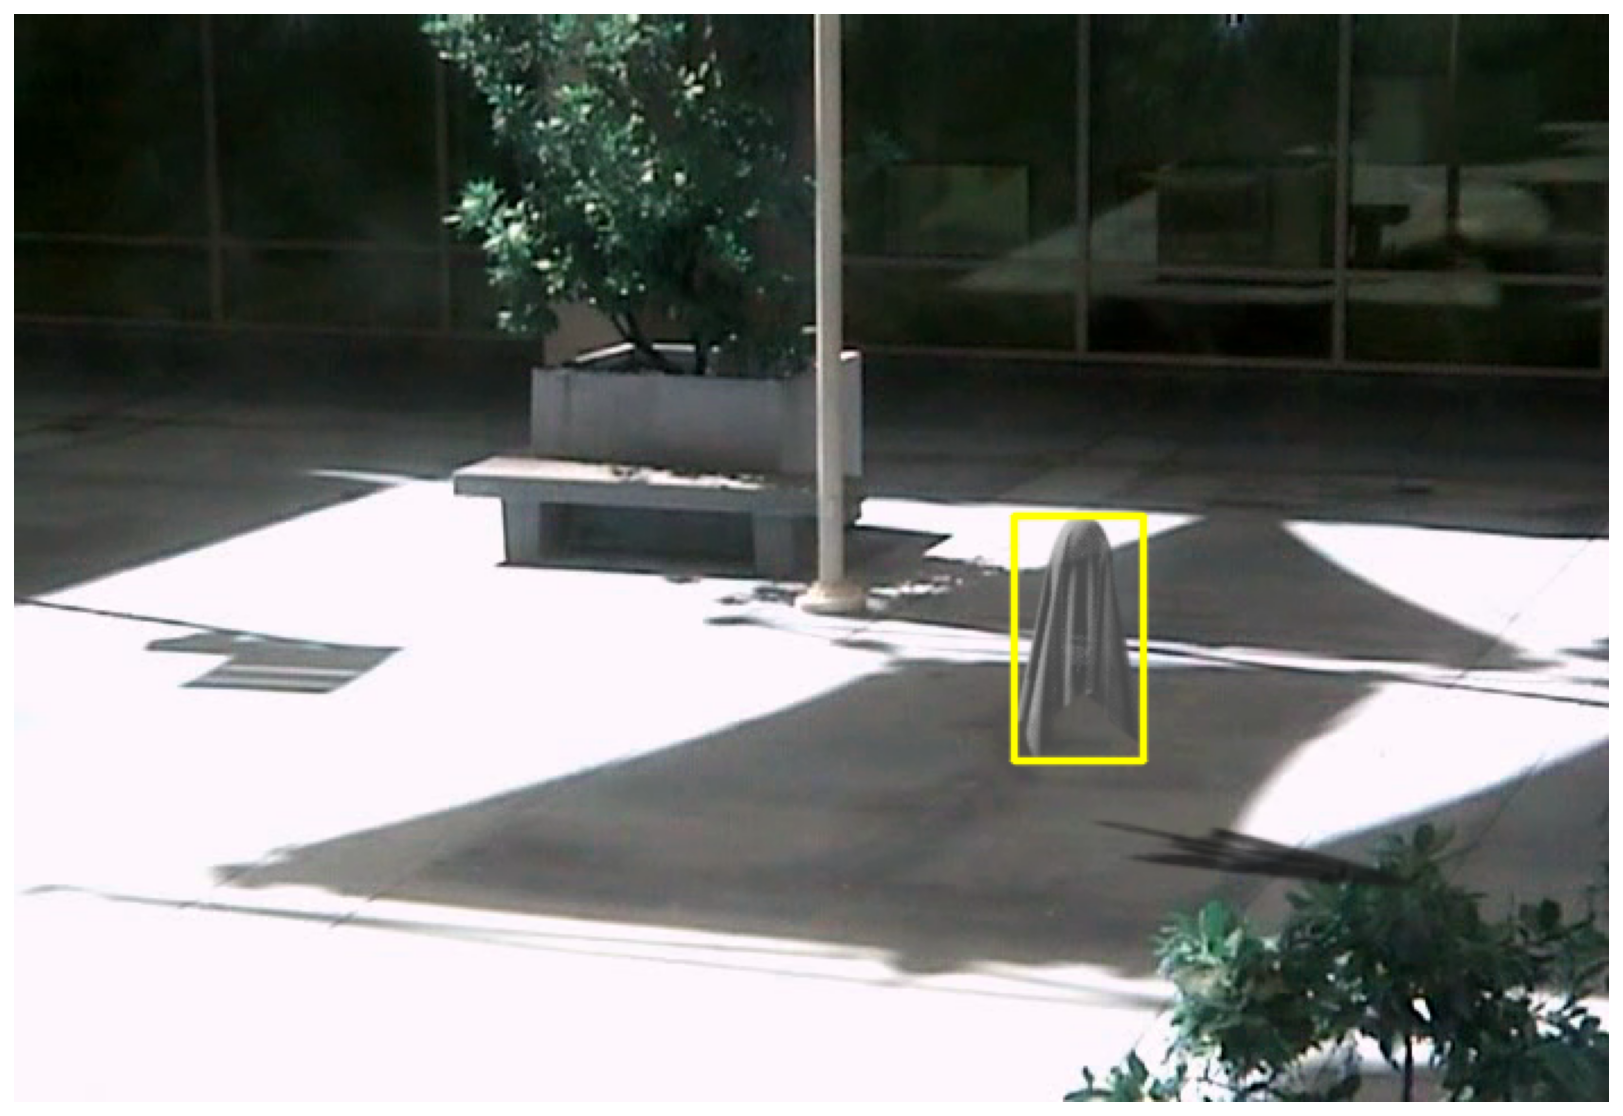

In [34]:
show_detected_objects(test_df.iloc[50])